In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import geopandas as gpd
from ema_workbench import load_results
from unbreakable.experiments.experiment_results_formatter import format_experiment_results

In [3]:
country = "Example"
disaster_type = "flood"
return_periond = 100

n_scenarios = 6
n_policies = 0

spu_name = 'Region'

results_path = (
    f"../../results/{country}/disaster_type={disaster_type}_return_period={return_periond}_scenarios={n_scenarios}_policies={n_policies}.tar.gz"
)
results = load_results(results_path)
results = format_experiment_results(results, include_policies=False, include_uncertainties=False)

## Economic impacts

In [4]:
economic_columns = [
    "avg_annual_consumption_loss",
    "avg_annual_consumption_loss_pct",
]
results['annual_average_consumption_loss_pct'] *= 100

In [5]:
results['annual_average_consumption_loss_pct'].describe()

count    18.000000
mean     18.640593
std       0.509090
min      18.074649
25%      18.241013
50%      18.468228
75%      19.239292
max      19.468463
Name: annual_average_consumption_loss_pct, dtype: float64

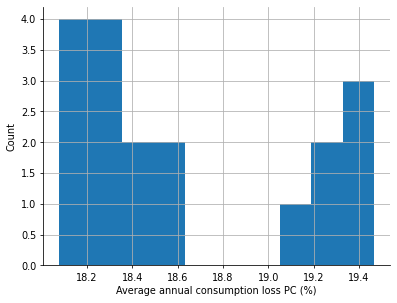

In [6]:
results['annual_average_consumption_loss_pct'].hist();
plt.ylabel("Count");
plt.xlabel("Average annual consumption loss PC (%)");
sns.despine()

In [7]:
results.groupby('spatial_unit')['annual_average_consumption_loss_pct'].describe()[['mean', 'std']].sort_values('mean', ascending=False).round(2)

,mean,std
spatial_unit,,
region_2,19.31,0.12
region_0,18.32,0.22
region_1,18.29,0.12


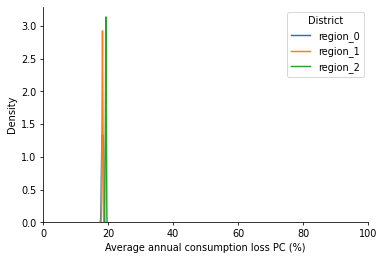

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for spatial_unit in results['spatial_unit'].unique():
    spatial_unit_results = results[results['spatial_unit'] == spatial_unit]
    sns.kdeplot(
            data=spatial_unit_results,
            x="annual_average_consumption_loss_pct",
            ax=ax,
            alpha=1,
            label=spatial_unit,
        )
    sns.despine()
plt.xlim(0, 100)
plt.xlabel("Average annual consumption loss PC (%)")
plt.ylabel("Density")
plt.legend(title="District");

## Poverty impacts

In [9]:
# TODO: It seems that there is no variance between the model runs.
new_poor_count = results.groupby('spatial_unit')['new_poor_count'].describe().round(2)
new_poor_count.index.name = 'District'
new_poor_count = new_poor_count.drop(columns=['count', 
                                              #'std',
                                               'min',
                                            #    '25%',
                                               '50%',
                                            #    '75%',
                                               'max'
                                              ])
new_poor_count.columns = ['Mean', 
                          'Std', 
                          'Min', 
                          # '25%', 
                          # '50%', 
                          # '75%', 
                          'Max'
                          ]
new_poor_count.sort_values('Mean', ascending=False).style.format("{:,.0f}")

,Mean,Std,Min,Max
District,,,,
region_0,0,0,0,0
region_1,0,0,0,0
region_2,0,0,0,0


In [10]:
poverty_duration_columns = [f'poverty_duration_{i}'for i in range(1, 11)]
poverty_duration = results[['spatial_unit'] + poverty_duration_columns].groupby('spatial_unit').mean().round(2).sort_values(by='poverty_duration_5', ascending=False).round()
poverty_duration.columns = np.arange(1, 11)
poverty_duration.index.name = spu_name
poverty_duration = poverty_duration.replace(0, np.nan)
poverty_duration.sort_values(1, ascending=False).iloc[:,:3].to_clipboard()

In [11]:
poverty_duration

,1,2,3,4,5,6,7,8,9,10
Region,,,,,,,,,,
region_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# TODO: It seems that there is no variance between the model runs.
df = results.groupby('spatial_unit')[['affected_people_count','new_poor_count']].mean()
df['affected_to_new_poor_ratio'] = df['new_poor_count'] / df['affected_people_count']
df.sort_values(['affected_to_new_poor_ratio', 'new_poor_count'], ascending=False).style.format("{:,.2f}")

,affected_people_count,new_poor_count,affected_to_new_poor_ratio
spatial_unit,,,
region_0,"1,058.27",0.00,0.00
region_1,"2,586.23",0.00,0.00
region_2,"1,633.89",0.00,0.00
